<a href="https://colab.research.google.com/github/SaloniJhalani/ChatGPT_Reviews_Sentiment_Analysis/blob/main/ChatGPT_Reviews_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary
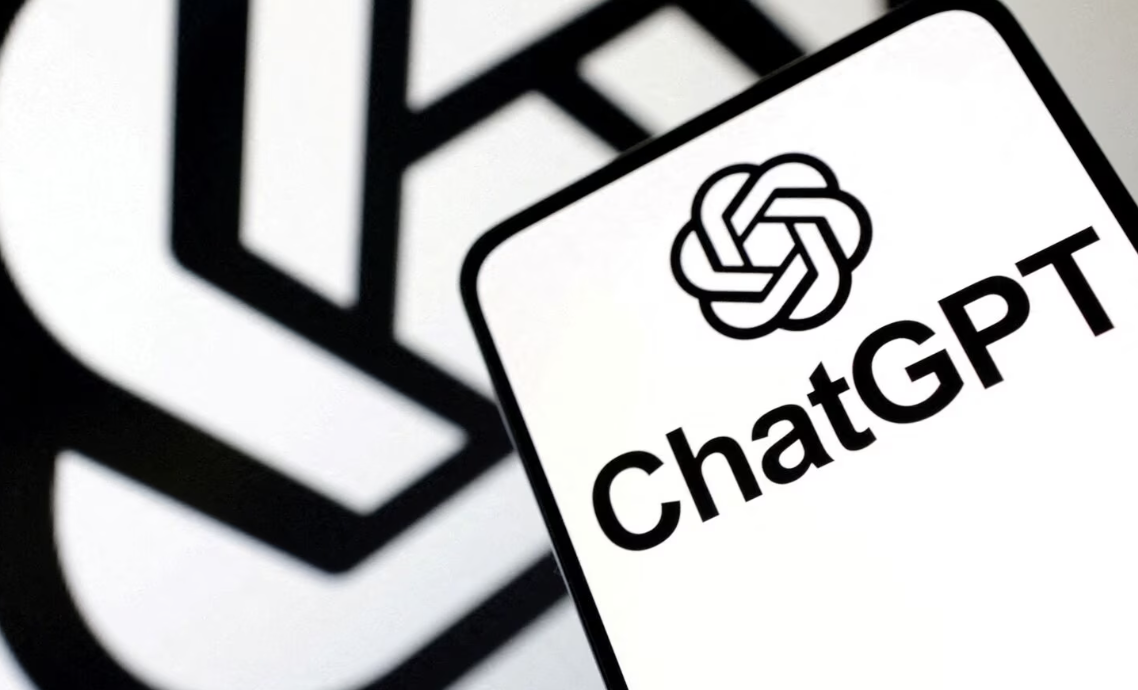

Sentiment analysis is the process of determining the sentiment or emotion expressed in a piece of text, such as a review or comment. It plays a crucial role in understanding the overall opinion or attitude of users towards a product, service, or any other subject. In this project, sentiment analysis is performed specifically on ChatGPT iOS reviews.

The data for this analysis is collected from the App Store, focusing on reviews related to ChatGPT. Basic exploratory data analysis (EDA) is conducted to gain insights into the dataset. Preprocessing steps are applied to clean the text data, including converting words to lowercase, removing punctuation and emojis, removing stop words, and performing lemmatization to reduce words to their base form.

After the initial preprocessing, word clouds are created to visualize the most frequent words associated with positive, negative, and neutral sentiments. These word clouds provide a quick overview of the commonly expressed sentiments in the reviews.

Further preprocessing steps involve transforming the text data into a numerical representation using bag-of-words vectorization. To address the issue of imbalanced data, the SMOTE (Synthetic Minority Over-sampling Technique) algorithm is applied to generate synthetic samples of the minority class.

Next, various classification models are trained and evaluated to find the best-performing model for sentiment analysis. Evaluation metrics such as precision, recall, and F1 score are utilized to assess the model's performance in predicting sentiment accurately.

In conclusion, this project presents an end-to-end approach for sentiment analysis of ChatGPT iOS reviews. By applying preprocessing techniques, exploratory data analysis, and employing classification models, the project aims to gain insights into the sentiments expressed in the reviews and predict sentiment with reasonable accuracy.



# Import Libraries

In [1]:
#Install Packages
!pip install app-store-scraper
!pip install wordcloud

#Import Libraries
from app_store_scraper import AppStore

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import json,os,uuid
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.6
    Uninstalling urllib3-2.0.6:
      Successfully uninstalled urllib3-2.0.6
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
      Successfully uninstalled idna-3.4
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into a

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data Collection

In [3]:
#Collect all the ChatGPT reviews from App Store
a_reviews = AppStore('us','chatgpt','6448311069')
a_reviews.review(sleep=1)

In [4]:
data = pd.DataFrame(np.array(a_reviews.reviews),columns=['review'])
data = data.join(pd.DataFrame(data.pop('review').tolist()))
data.head()

,date,review,rating,isEdited,title,userName
0,2023-09-12 19:05:19,Very much love the app. Way better than Google...,5,False,"Love it, been using it since last year",Tj77883344
1,2023-09-10 02:45:51,Up to this point I’ve mostly been using ChatGP...,4,False,Much more accessible for blind users than the ...,PDXJavaJunkie
2,2023-07-11 12:24:19,I’ve been a user since it’s initial roll out a...,4,False,"Much anticipated, wasn’t let down.",Tinny tower addicted
3,2023-05-27 21:57:27,"I recently downloaded the app and overall, it'...",4,False,"4.5 stars, here’s why",Would Po
4,2023-09-20 15:54:11,"Oh my gosh, I cannot explain how much I’ve use...",5,False,Always quick!,MORE FREE PAINTINGS!!!


In [5]:
data.shape

(4371, 6)

In [6]:
data.drop(['isEdited','userName'],axis=1,inplace=True) #Delete columns
data = data[['date','title','review','rating']] #Rearrange columns
data.head()

,date,title,review,rating
0,2023-09-12 19:05:19,"Love it, been using it since last year",Very much love the app. Way better than Google...,5
1,2023-09-10 02:45:51,Much more accessible for blind users than the ...,Up to this point I’ve mostly been using ChatGP...,4
2,2023-07-11 12:24:19,"Much anticipated, wasn’t let down.",I’ve been a user since it’s initial roll out a...,4
3,2023-05-27 21:57:27,"4.5 stars, here’s why","I recently downloaded the app and overall, it'...",4
4,2023-09-20 15:54:11,Always quick!,"Oh my gosh, I cannot explain how much I’ve use...",5


In [9]:
#Storing Data
data.to_csv('chatgpt_reviews.csv',index=False)

# Exploratory Data Analysis

In [11]:
data = pd.read_csv('chatgpt_reviews.csv')

In [12]:
data.shape

(4371, 4)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4371 entries, 0 to 4370
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    4371 non-null   object
 1   title   4371 non-null   object
 2   review  4371 non-null   object
 3   rating  4371 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 136.7+ KB


In [14]:
data.describe()

,rating
count,4371.000000
mean,3.974377
std,1.517792
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


In [15]:
data.describe(include='object')

,date,title,review
count,4371,4371,4371
unique,4365,3677,4308
top,2023-05-18 23:45:42,Amazing,Great
freq,2,57,8


<h3> Analysis of Rating column </h3>

In [17]:
#Rating Distribution
data['rating'].value_counts().sort_index()

1     694
2     203
3     318
4     462
5    2694
Name: rating, dtype: int64

In [18]:
data['rating'].value_counts(normalize=True).mul(100).round(2).sort_index()

1    15.88
2     4.64
3     7.28
4    10.57
5    61.63
Name: rating, dtype: float64

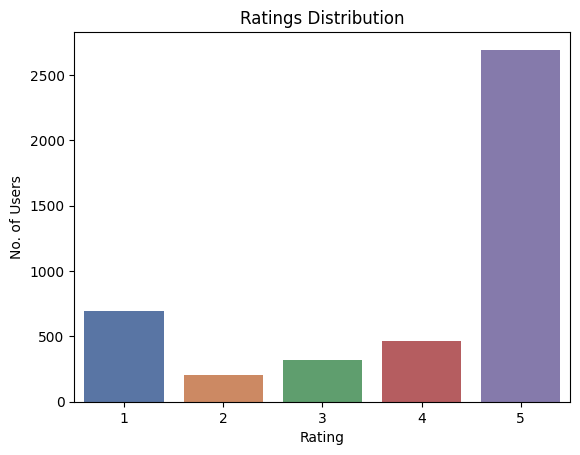

In [19]:
#Plot
palette = "deep"
sns.set_palette(palette)

sns.countplot(data=data, x='rating')

plt.xlabel('Rating')
plt.ylabel('No. of Users')
plt.title('Ratings Distribution')

plt.show()

# Data Preprocessing

In [20]:
#Find no. of missing values in each column
data.isnull().sum().sort_values(ascending=False)

date      0
title     0
review    0
rating    0
dtype: int64

In [21]:
#Combine Review Time and Review
data['complete_review'] = data['title'] +' .'+data['review']

In [22]:
#Drop some columns which we won't use for sentiment analysis of review
remove_cols = ['date','review','title']
data = data.drop(remove_cols,axis='columns')

In [23]:
data.head()

,rating,complete_review
0,5,"Love it, been using it since last year .Very m..."
1,4,Much more accessible for blind users than the ...
2,4,"Much anticipated, wasn’t let down. .I’ve been ..."
3,4,"4.5 stars, here’s why .I recently downloaded t..."
4,5,"Always quick! .Oh my gosh, I cannot explain ho..."


1. Convert all the reviews to lowercase

In [24]:
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['complete_review'].head()

0    love it, been using it since last year .very m...
1    much more accessible for blind users than the ...
2    much anticipated, wasn’t let down. .i’ve been ...
3    4.5 stars, here’s why .i recently downloaded t...
4    always quick! .oh my gosh, i cannot explain ho...
Name: complete_review, dtype: object

2. Remove Punctuation

In [25]:
data['complete_review'] = data['complete_review'].str.replace('[^\w\s]','')

3. Remove Emojis

In [26]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
data['complete_review'] = data['complete_review'].apply(lambda x: remove_emoji(x))

4. Remove Stopwords

Stopwords are commonly used words (i.e. “the”, “a”, “an”) that do not add meaning to a sentence and can be ignored without having a drastic effect on the meaning of the sentence.

In [27]:
stop = stopwords.words('english')
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

5. Apply Lemmatization

In [28]:
def space(comment):
    doc = nlp(comment)
    return " ".join([token.lemma_ for token in doc])
data['complete_review']= data['complete_review'].apply(space)

6. Remove certain words

  These are specific to app and won't show any sentiments

In [29]:
words_to_remove = ['chatgpt','app','chatgpts','chat','gpt','iphone','ipad','gpt4','phone','number','ai','use','io']
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x for x in x.split() if x not in words_to_remove))

7. Map ratings to positive, negative & neutral sentiment

0 will represent negative sentiment

1 will represent neutral sentiment

2 will represent positive sentiment


In [31]:
data['sentiment'] = data['rating'].apply(lambda rating: 2 if rating > 3 else (1 if rating == 3 else 0))
data.head(5)

,rating,complete_review,sentiment
0,5,love since last year much love way well google...,2
1,4,much accessible blind user web version point I...,2
2,4,much anticipate be not let I ve user since ini...,2
3,4,45 star here recently download overall great p...,2
4,5,always quick oh gosh can not explain much I ve...,2


In [32]:
data['sentiment'].value_counts(normalize=True).mul(100).round(2)

2    72.20
0    20.52
1     7.28
Name: sentiment, dtype: float64

Data is Imbalanced as about 66% of sentiment is positive, 24% is negative and 9.5% is neutral.

# Reviews Analysis

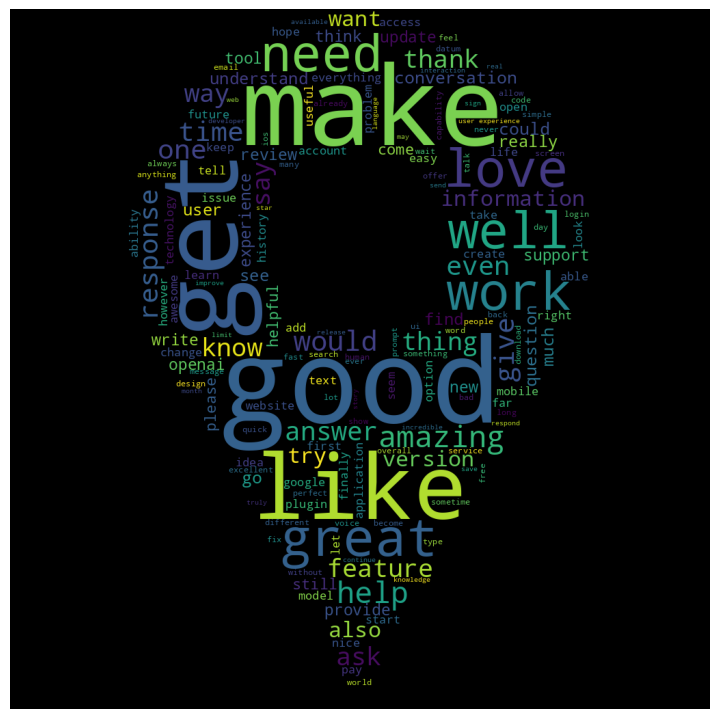

In [ ]:
#Analysis of Review field
stopword = set(stopwords.words('english'))
text = " ".join(review for review in data.complete_review)
mask = np.array(Image.open("loc.png"))
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopword,
                min_font_size = 10, mask=mask).generate(text)

# plot the WordCloud image
plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('review_sentiment.png')
plt.show()

In [ ]:
#positive negative & neutral sentiment:
positive = data[data['sentiment'] == 2]
negative = data[data['sentiment'] == 0]
neutral = data[data['sentiment'] == 1]

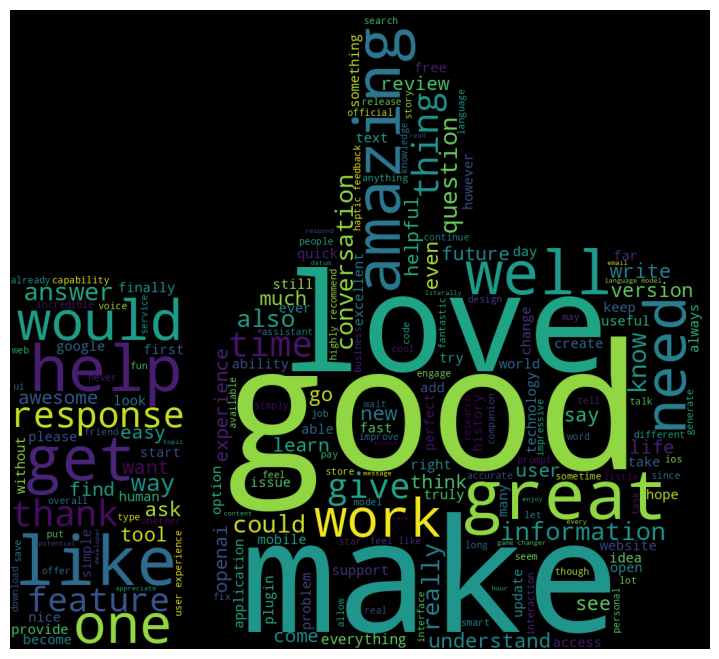

In [ ]:
#Positive Setiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in positive.complete_review)
mask = np.array(Image.open("thumbs_up.png"))
wordcloud = WordCloud(width = 2200, height = 2300,
                background_color ='black',
                stopwords = stopword,
                min_font_size = 10, mask=mask).generate(text)

# plot the WordCloud image
plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('positive_sentiment.png')
plt.show()
wordcloud.to_file("posid.png")

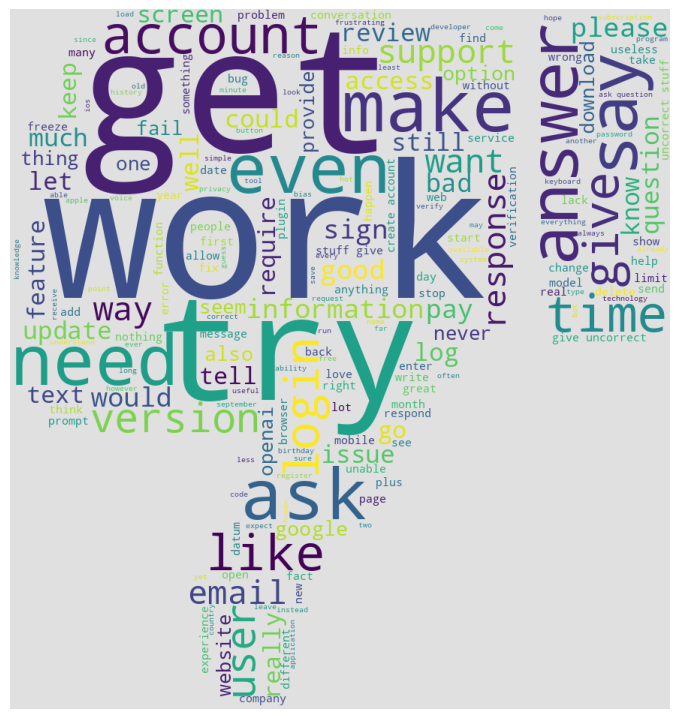

In [ ]:
#Negative Setiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in negative.complete_review)
mask = np.array(Image.open("./thumbs_down.png"))
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='#E0E0E0',
                stopwords = stopword,
                min_font_size = 10, mask=mask).generate(text)

# plot the WordCloud image
plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('negative_sentiment.png')
plt.show()

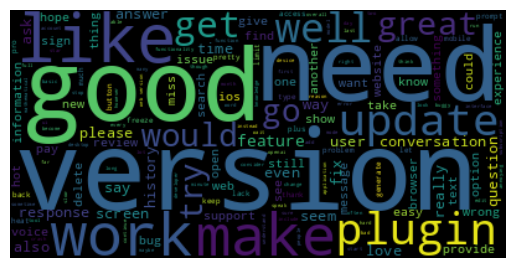

In [ ]:
#Neutral Sentiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in neutral.complete_review)
wordcloud = WordCloud(stopwords=stopword).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Sentiment Analysis Model

<h3> Bag of Word Vectorization </h3>

In [ ]:
#Pre-Prcoessing and Bag of Word Vectorization using Count Vectorizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
X = cv.fit_transform(data['complete_review'])
y = data['sentiment']

<h3> Handle Imbalanced Data </h3>

In [ ]:
# Instantiate the SMOTE object
smote = SMOTE()

# Perform oversampling
X_oversampled, y_oversampled = smote.fit_resample(X, y)

<h3> Train Test Split </h3>

In [ ]:
#Train Test split
X_train, X_test, y_train, y_test = train_test_split(X_oversampled,
                                                  y_oversampled,
                                                  test_size=0.15,
                                                  random_state=17,stratify=y_oversampled)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7716, 7352)
(1362, 7352)
(7716,)
(1362,)


<h3> Multinomial Naive Bayes </h3>

In [ ]:
#Training the model
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

#Caluclating the accuracy score of the model
y_pred = MNB.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.85      0.57      0.68       679
           1       0.39      0.67      0.49       263
           2       0.77      0.83      0.80       420

    accuracy                           0.67      1362
   macro avg       0.67      0.69      0.66      1362
weighted avg       0.73      0.67      0.68      1362



<h3> Logistic Regression </h3>

In [ ]:
# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.48      0.75      0.58       291
           1       0.89      0.59      0.71       682
           2       0.78      0.92      0.84       389

    accuracy                           0.72      1362
   macro avg       0.72      0.75      0.71      1362
weighted avg       0.77      0.72      0.72      1362



<h3> Random Forest </h3>

In [ ]:
# Initialize and train the random forest classifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.44      0.80      0.57       250
           1       0.91      0.60      0.72       687
           2       0.80      0.86      0.83       425

    accuracy                           0.72      1362
   macro avg       0.72      0.75      0.71      1362
weighted avg       0.79      0.72      0.73      1362



<h3> XGBoost </h3>

In [ ]:
# Create DMatrix for training and testing data
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set the parameters for XGBoost
params = {
    'objective': 'multi:softmax',  # Set the objective function for multi-class classification
    'num_class': 3,      # Number of classes in the dataset
    'eval_metric': 'merror',        # Evaluation metric (multi-class classification error rate)
    'eta': 0.4,                    # Learning rate
    'max_depth': 6,                # Maximum depth of a tree
    'subsample': 0.8,              # Subsample ratio of the training instances
    'colsample_bytree': 0.8,       # Subsample ratio of features when constructing each tree
    'seed': 42                     # Random seed for reproducibility
}

# Train the XGBoost model
num_rounds = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the testing data
preds = model.predict(dtest)
pred_labels = [int(pred) for pred in preds]

print(classification_report(pred_labels, y_test))

              precision    recall  f1-score   support

           0       0.83      0.90      0.87       422
           1       0.89      0.95      0.92       421
           2       0.94      0.82      0.87       519

    accuracy                           0.89      1362
   macro avg       0.89      0.89      0.89      1362
weighted avg       0.89      0.89      0.89      1362



#Conclusion

The best-performing model was identified as XGBoost, which achieved an accuracy of 87% with the f1-score of 0.85 and above for all the labels(positive,negative & neutral). This model demonstrates the ability to accurately predict sentiment based on ChatGPT iOS reviews.

Overall, with the developed sentiment analysis model, we can effectively analyze and understand the sentiment expressed in ChatGPT reviews. This provides valuable insights for businesses, helping them make informed decisions, improve customer satisfaction, and enhance their products and services based on customer feedback.

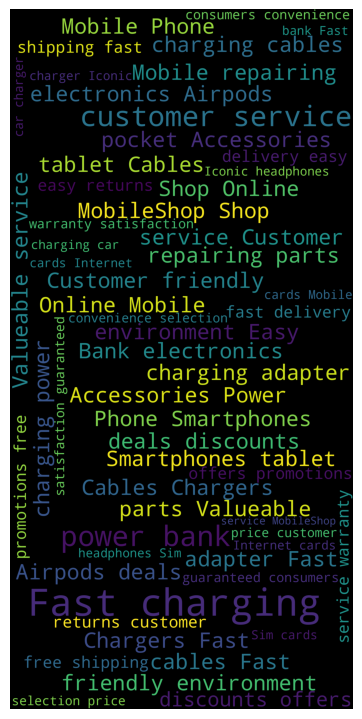

In [ ]:
#Positive Setiment
text = "MobileShop, Shop Online, Mobile Phone, Smartphones,tablet, Cables, Chargers,Fast charging adapter,Fast charging cables,Fast charging power bank,Fast charging car charger,Iconic headphones,Sim cards,Internet cards,Mobile repairing parts,Valueable service,Customer friendly environment,Easy to pocket, Accessories,Power Bank ,electronics,Airpods,deals,discounts,offers, promotions, free shipping,fast delivery,easy returns, customer service, warranty, satisfaction guaranteed,consumers, convenience, selection, price, customer service,MobileShop, Shop Online, Mobile Phone, Smartphones,tablet, Cables, Chargers,Fast charging adapter,Fast charging cables,Fast charging power bank,Fast charging car charger,Iconic headphones,Sim cards,Internet cards,Mobile repairing parts,Valueable service,Customer friendly environment,Easy to pocket, Accessories,Power Bank ,electronics,Airpods,deals,discounts,offers, promotions, free shipping,fast delivery,easy returns, customer service, warranty, satisfaction guaranteed,consumers, convenience, selection, price, customer service,MobileShop, Shop Online, Mobile Phone, Smartphones,tablet, Cables, Chargers,Fast charging adapter,Fast charging cables,Fast charging power bank,Fast charging car charger,Iconic headphones,Sim cards,Internet cards,Mobile repairing parts,Valueable service,Customer friendly environment,Easy to pocket, Accessories,Power Bank ,electronics,Airpods,deals,discounts,offers, promotions, free shipping,fast delivery,easy returns, customer service, warranty, satisfaction guaranteed,consumers, convenience, selection, price, customer service,MobileShop, Shop Online, Mobile Phone, Smartphones,tablet, Cables, Chargers,Fast charging adapter,Fast charging cables,Fast charging power bank,Fast charging car charger,Iconic headphones,Sim cards,Internet cards,Mobile repairing parts,Valueable service,Customer friendly environment,Easy to pocket, Accessories,Power Bank ,electronics,Airpods,deals,discounts,offers, promotions, free shipping,fast delivery,easy returns, customer service, warranty, satisfaction guaranteed,consumers, convenience, selection, price, customer service,MobileShop, Shop Online, Mobile Phone, Smartphones,tablet, Cables, Chargers,Fast charging adapter,Fast charging cables,Fast charging power bank,Fast charging car charger,Iconic headphones,Sim cards,Internet cards,Mobile repairing parts,Valueable service,Customer friendly environment,Easy to pocket, Accessories,Power Bank ,electronics,Airpods,deals,discounts,offers, promotions, free shipping,fast delivery,easy returns, customer service, warranty, satisfaction guaranteed,consumers, convenience, selection, price, customer service,MobileShop, Shop Online, Mobile Phone, Smartphones,tablet, Cables, Chargers,Fast charging adapter,Fast charging cables,Fast charging power bank,Fast charging car charger,Iconic headphones,Sim cards,Internet cards,Mobile repairing parts,Valueable service,Customer friendly environment,Easy to pocket, Accessories,Power Bank ,electronics,Airpods,deals,discounts,offers, promotions, free shipping,fast delivery,easy returns, customer service, warranty, satisfaction guaranteed,consumers, convenience, selection, price, customer service,MobileShop, Shop Online, Mobile Phone, Smartphones,tablet, Cables, Chargers,Fast charging adapter,Fast charging cables,Fast charging power bank,Fast charging car charger,Iconic headphones,Sim cards,Internet cards,Mobile repairing parts,Valueable service,Customer friendly environment,Easy to pocket, Accessories,Power Bank ,electronics,Airpods,deals,discounts,offers, promotions, free shipping,fast delivery,easy returns, customer service, warranty, satisfaction guaranteed,consumers, convenience, selection, price, customer service,MobileShop, Shop Online, Mobile Phone, Smartphones,tablet, Cables, Chargers,Fast charging adapter,Fast charging cables,Fast charging power bank,Fast charging car charger,Iconic headphones,Sim cards,Internet cards,Mobile repairing parts,Valueable service,Customer friendly environment,Easy to pocket, Accessories,Power Bank ,electronics,Airpods,deals,discounts,offers, promotions, free shipping,fast delivery,easy returns, customer service, warranty, satisfaction guaranteed,consumers, convenience, selection, price, customer service,MobileShop, Shop Online, Mobile Phone, Smartphones,tablet, Cables, Chargers,Fast charging adapter,Fast charging cables,Fast charging power bank,Fast charging car charger,Iconic headphones,Sim cards,Internet cards,Mobile repairing parts,Valueable service,Customer friendly environment,Easy to pocket, Accessories,Power Bank ,electronics,Airpods,deals,discounts,offers, promotions, free shipping,fast delivery,easy returns, customer service, warranty, satisfaction guaranteed,consumers, convenience, selection, price, customer service,MobileShop, Shop Online, Mobile Phone, Smartphones,tablet, Cables, Chargers,Fast charging adapter,Fast charging cables,Fast charging power bank,Fast charging car charger,Iconic headphones,Sim cards,Internet cards,Mobile repairing parts,Valueable service,Customer friendly environment,Easy to pocket, Accessories,Power Bank ,electronics,Airpods,deals,discounts,offers, promotions, free shipping,fast delivery,easy returns, customer service, warranty, satisfaction guaranteed,consumers, convenience, selection, price, customer service,MobileShop, Shop Online, Mobile Phone, Smartphones,tablet, Cables, Chargers,Fast charging adapter,Fast charging cables,Fast charging power bank,Fast charging car charger,Iconic headphones,Sim cards,Internet cards,Mobile repairing parts,Valueable service,Customer friendly environment,Easy to pocket, Accessories,Power Bank ,electronics,Airpods,deals,discounts,offers, promotions, free shipping,fast delivery,easy returns, customer service, warranty, satisfaction guaranteed,consumers, convenience, selection, price, customer service,MobileShop, Shop Online, Mobile Phone, Smartphones,tablet, Cables, Chargers,Fast charging adapter,Fast charging cables,Fast charging power bank,Fast charging car charger,Iconic headphones,Sim cards,Internet cards,Mobile repairing parts,Valueable service,Customer friendly environment,Easy to pocket, Accessories,Power Bank ,electronics,Airpods,deals,discounts,offers, promotions, free shipping,fast delivery,easy returns, customer service, warranty, satisfaction guaranteed,consumers, convenience, selection, price, customer service,MobileShop, Shop Online, Mobile Phone, Smartphones,tablet, Cables, Chargers,Fast charging adapter,Fast charging cables,Fast charging power bank,Fast charging car charger,Iconic headphones,Sim cards,Internet cards,Mobile repairing parts,Valueable service,Customer friendly environment,Easy to pocket, Accessories,Power Bank ,electronics,Airpods,deals,discounts,offers, promotions, free shipping,fast delivery,easy returns, customer service, warranty, satisfaction guaranteed,consumers, convenience, selection, price, customer service,MobileShop, Shop Online, Mobile Phone, Smartphones,tablet, Cables, Chargers,Fast charging adapter,Fast charging cables,Fast charging power bank,Fast charging car charger,Iconic headphones,Sim cards,Internet cards,Mobile repairing parts,Valueable service,Customer friendly environment,Easy to pocket, Accessories,Power Bank ,electronics,Airpods,deals,discounts,offers, promotions, free shipping,fast delivery,easy returns, customer service, warranty, satisfaction guaranteed,consumers, convenience, selection, price, customer service,MobileShop, Shop Online, Mobile Phone, Smartphones,tablet, Cables, Chargers,Fast charging adapter,Fast charging cables,Fast charging power bank,Mobile repairing parts,Valueable service,Customer friendly environment,Easy to pocket, Accessories,Power Bank ,electronics,Airpods,deals,discounts,offers, promotions, free shipping,fast delivery,easy returns, customer service, warranty, satisfaction guaranteed,consumers, convenience, selection, price, customer service,MobileShop, Shop Online, Mobile Phone, Smartphones,tablet, Cables, Chargers,Fast charging adapter,Fast charging cables,Fast charging power bank,Fast charging car charger,Iconic headphones,Sim cards,Internet cards,Mobile repairing parts,Valueable service,Customer friendly environment,Easy to pocket, Accessories,Power Bank ,electronics,Airpods,deals,discounts,offers, promotions, free shipping,fast delivery,easy returns, customer service, warranty, satisfaction guaranteed,consumers, convenience, selection, price, customer service"

mask = np.array(Image.open("sm3.png"))
wordcloud = WordCloud(width = 1700, height = 3300,
                 background_color ='black',
                min_font_size = 30, mask=mask).generate(text)

# plot the WordCloud image
plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('pds.png')
plt.show()
wordcloud.to_file("spd.png")



In [8]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

image_path = "sm.png"
image = Image.open(image_path)

wordcloud = WordCloud( background_color ='#E0E0E0',mask=mask)
text = "Mobile Shop, Shop Online, Mobile Phone, Smartphones,tablet, Cables, Chargers, Accessories,Power Bank ,electronics,Airpods,deals,discounts,offers, promotions, free shipping,fast delivery,easy returns, customer service, warranty, satisfaction guaranteed,consumers, convenience, selection, price, customer service"
wordcloud.generate(text)

plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Save the wordcloud image (optional)
wordcloud.to_file("wordcloud.png")

FileNotFoundError: ignored